In [1]:
# !pip install psycopg2

In [17]:
import psycopg2
import numpy as np
from scipy.special import rel_entr
from scipy.special import kl_div
from scipy.stats import entropy
from collections import defaultdict
# Making connection to postgres database
conn = psycopg2.connect(database='census_db', user='rachn', password='password')

cur = conn.cursor()
cur.execute('SELECT * FROM census LIMIT 5')
head_5 = cur.fetchall()

print("First 5 rows of census table:")
for row in head_5:
    print(row)

cur.execute('SELECT COUNT(*) FROM census')
total_rows = cur.fetchone()[0]
print("Total rows in census table:", total_rows)

# conn.close()


First 5 rows of census table:
(1, 39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0, 40, ' United-States', ' <=50K')
(2, 50, ' Self-emp-not-inc', 83311, ' Bachelors', 13, ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', 0, 0, 13, ' United-States', ' <=50K')
(3, 38, ' Private', 215646, ' HS-grad', 9, ' Divorced', ' Handlers-cleaners', ' Not-in-family', ' White', ' Male', 0, 0, 40, ' United-States', ' <=50K')
(4, 53, ' Private', 234721, ' 11th', 7, ' Married-civ-spouse', ' Handlers-cleaners', ' Husband', ' Black', ' Male', 0, 0, 40, ' United-States', ' <=50K')
(5, 28, ' Private', 338409, ' Bachelors', 13, ' Married-civ-spouse', ' Prof-specialty', ' Wife', ' Black', ' Female', 0, 0, 40, ' Cuba', ' <=50K')
Total rows in census table: 32561


In [18]:
def kl_divergence(prob1, prob2):
    prob1 = prob1/np.sum(np.asarray(prob1, dtype=float))
    prob2 = prob2/np.sum(np.asarray(prob2, dtype=float))
    # Clipping values of prob2 between eps and positive infinity to avoid dividing by 0
    prob2 = np.clip(prob2, np.finfo(float).eps, None)
    return np.sum(prob1 * np.log(prob1 / prob2))
    
# # Testing kl divergence
# prob1 = [0.25, 0.33, 0.23, 0.19]
# prob2 = [0.21, 0.21, 0.32, 0.26]
# kl_divergence(prob1, prob2)

In [19]:
query_ds_cond = "marital_status in (' Married-civ-spouse', ' Married-spouse-absent', ' Married-AF-spouse')"
ref_ds_cond = "marital_status in (' Divorced', ' Never-married', ' Separated', ' Widowed')"

measures = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
dimensions = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
agg_functions = ['avg', 'sum', 'min', 'max', 'count']

In [20]:
views = defaultdict(lambda: defaultdict(set))
for dim in dimensions:
    for measure in measures:
        views[dim][measure] = (set(agg_functions))


In [21]:
def check_or_correct_no_of_rows(attribute, query_dataset_rows, reference_dataset_rows, start_idx, end_idx):
    if len(query_dataset_rows) != len(reference_dataset_rows):
        zeros_row = np.zeros((1, reference_dataset_rows.shape[1]), dtype=float)
        query_dataset_query = f"""
        SELECT __atr__, count(*)
        FROM (
            SELECT DISTINCT({attribute}) AS __atr__
            FROM census
            WHERE {query_ds_cond}
            AND id >= %s AND id < %s
        ) AS attrs
        LEFT OUTER JOIN census ON __atr__ = {attribute}
        WHERE {query_ds_cond}
        GROUP BY __atr__
        ORDER BY __atr__
    """
        cur.execute(query_dataset_query, (start_idx, end_idx))
        query_dataset = np.array(cur.fetchall()).astype(str)

        ref_dataset_query = f"""
        SELECT __atr__, count(*)
        FROM (
            SELECT DISTINCT({attribute}) AS __atr__
            FROM census
            WHERE {ref_ds_cond}
            AND id >= %s AND id < %s
        ) AS attrs
        LEFT OUTER JOIN census ON __atr__ = {attribute}
        WHERE {query_ds_cond}
        GROUP BY __atr__
        ORDER BY __atr__
    """
        cur.execute(ref_dataset_query, (start_idx, end_idx))
        ref_dataset = np.array(cur.fetchall()).astype(str)

        for i in range(len(query_dataset)):
            if (i<len(ref_dataset) and query_dataset[i][0] != ref_dataset[i][0]) or (i>=len(ref_dataset)):
                reference_dataset_rows = np.insert(reference_dataset_rows, i, zeros_row, axis=0)
                ref_dataset = np.insert(ref_dataset, i, np.array([query_dataset[i][0], '0']), axis=0)
    return reference_dataset_rows
    

In [22]:
# Creating partitions of the data
num_partitions = 10
partition_size = total_rows // num_partitions
phase_num = 0
view_num = -1
for i in range(num_partitions):
    start_idx = i * partition_size + 1
    end_idx = 1 + ((i + 1) * partition_size - 1 if i != num_partitions - 1 else total_rows - 1)
    print(start_idx, end_idx)
    phase_num += 1
    view_distance_mappings = dict()
    view_dist = []
    view_num = -1
    for attribute in views:
        selections = ''
        for measure in views[attribute]:
            for func in views[attribute][measure]:
                selections += f'COALESCE({func}({measure}), 0), '
        selections = selections[:-2]          
        print(selections)
        query_dataset_query = f"""
        SELECT {selections}
        FROM (
            SELECT DISTINCT({attribute}) AS __atr__
            FROM census
            WHERE {query_ds_cond}
            AND id >= %s AND id < %s
        ) AS attrs
        LEFT OUTER JOIN census ON __atr__ = {attribute}
        WHERE {query_ds_cond}
        GROUP BY __atr__
        ORDER BY __atr__
    """
    
        reference_dataset_query = f"""
        SELECT {selections}
        FROM (
            SELECT DISTINCT({attribute}) AS __atr__
            FROM census
            WHERE {ref_ds_cond}
            AND id >= %s AND id < %s
        ) AS attrs
        LEFT OUTER JOIN census ON __atr__ = {attribute}
        WHERE {ref_ds_cond}
        GROUP BY __atr__
        ORDER BY __atr__
    """
        cur.execute(query_dataset_query, (start_idx, end_idx))
        
            # print(query_dataset_query, (start_idx, end_idx))
        query_dataset_rows = np.array(cur.fetchall()).astype(float)
        print(query_dataset_rows)
        cur.execute(reference_dataset_query, (start_idx, end_idx))
        reference_dataset_rows = np.array(cur.fetchall()).astype(float)
        # print("Dimensions of reference_dataset_rows1:", reference_dataset_rows.shape)
        reference_dataset_rows = check_or_correct_no_of_rows(attribute, query_dataset_rows, reference_dataset_rows, start_idx, end_idx)
        # print("Dimensions of reference_dataset_rows2:", reference_dataset_rows.shape)

        # Pruning based optimization
        column_num = -1
        for measure in views[attribute]:
            for func in views[attribute][measure]:
                view_num += 1
                column_num += 1
                d = 0
                try:
                    d = kl_divergence(query_dataset_rows[:, column_num], reference_dataset_rows[:, column_num])
                    print("d is: ", d)
                except Exception as e:
                    # print("Attribute name is: ", attribute)
                    pass
                if np.isnan(d):
                    # print(attribute, measure, func)
                    view_dist.append(0)
                else:
                    view_dist.append(d)
                view_distance_mappings[view_num] = (attribute, measure, func)
                
    pruned_candidates = []
    pruned_candidates_indexes = []
    index = []
    # print("View_dist are: ", view_dist)
    kl_divg = np.array(view_dist)
    if phase_num != 1:
        num_candidates = len(kl_divg)
        # print("kl_divg is: ", kl_divg)
        # sort the kl divergences
        sorted_divergences = np.sort(kl_divg)[::-1]
        # print("kl_sorted is:", sorted_divergences)
        index = np.argsort(kl_divg)[::-1]
        if phase_num == num_partitions:
            pruned_candidates_indexes = index[5:]
        else:
            # Calculate the confidence interval
            delta = 0.05
            numerator = (1 -(phase_num/num_partitions)) * (2*np.log(np.log(phase_num+1)) + np.log(np.pi**2/(3*delta)))
            denominator = 2*(phase_num+1)
            confidence_interval_error_margin = np.sqrt(numerator/denominator)
            # min_factor = kl_sorted[4] - confidence_interval_error_margin
            for i in range(5, num_candidates):    
                if sorted_divergences[4] - confidence_interval_error_margin > confidence_interval_error_margin + sorted_divergences[i]:
                    pruned_candidates_indexes = index[i:]
    for index_value in pruned_candidates_indexes:
        pruned_candidates.append(view_distance_mappings[index_value])
    # pruned_candidates = [view_distance_mappings[idx]
    #                         for idx in pruned_candidates_indexes]
    for dimension, measure, func in pruned_candidates:
        views[dimension][measure].remove(func)
        if not views[dimension][measure]:
            del views[dimension][measure]
            if not views[dimension]:
                del views[dimension]
                    
recommended_views = []     
final_reccos = [(d, m, f) for d in views for m in views[d] for f in views[d][m]]
print("Recommended views are: ", final_reccos) 


1 3256
COALESCE(count(age), 0), COALESCE(sum(age), 0), COALESCE(avg(age), 0), COALESCE(min(age), 0), COALESCE(max(age), 0), COALESCE(count(capital_gain), 0), COALESCE(sum(capital_gain), 0), COALESCE(avg(capital_gain), 0), COALESCE(min(capital_gain), 0), COALESCE(max(capital_gain), 0), COALESCE(count(capital_loss), 0), COALESCE(sum(capital_loss), 0), COALESCE(avg(capital_loss), 0), COALESCE(min(capital_loss), 0), COALESCE(max(capital_loss), 0), COALESCE(count(hours_per_week), 0), COALESCE(sum(hours_per_week), 0), COALESCE(avg(hours_per_week), 0), COALESCE(min(hours_per_week), 0), COALESCE(max(hours_per_week), 0)
[[6.67000000e+02 3.57600000e+04 5.36131934e+01 1.90000000e+01
  9.00000000e+01 6.67000000e+02 7.32558000e+05 1.09828786e+03
  0.00000000e+00 9.99990000e+04 6.67000000e+02 5.31560000e+04
  7.96941529e+01 0.00000000e+00 2.60300000e+03 6.67000000e+02
  2.12290000e+04 3.18275862e+01 1.00000000e+00 9.90000000e+01]
 [4.85000000e+02 2.16500000e+04 4.46391753e+01 1.90000000e+01
  9.0000

C:\Users\rachn\AppData\Local\Temp\ipykernel_2560\73027522.py:2: RuntimeWarning: invalid value encountered in divide
  prob1 = prob1/np.sum(np.asarray(prob1, dtype=float))
C:\Users\rachn\AppData\Local\Temp\ipykernel_2560\73027522.py:3: RuntimeWarning: invalid value encountered in divide
  prob2 = prob2/np.sum(np.asarray(prob2, dtype=float))


COALESCE(count(age), 0), COALESCE(sum(age), 0), COALESCE(avg(age), 0), COALESCE(min(age), 0), COALESCE(max(age), 0), COALESCE(count(capital_gain), 0), COALESCE(sum(capital_gain), 0), COALESCE(avg(capital_gain), 0), COALESCE(min(capital_gain), 0), COALESCE(max(capital_gain), 0), COALESCE(count(capital_loss), 0), COALESCE(sum(capital_loss), 0), COALESCE(avg(capital_loss), 0), COALESCE(min(capital_loss), 0), COALESCE(max(capital_loss), 0), COALESCE(count(hours_per_week), 0), COALESCE(sum(hours_per_week), 0), COALESCE(avg(hours_per_week), 0), COALESCE(min(hours_per_week), 0), COALESCE(max(hours_per_week), 0)
[[1.31930000e+04 5.78099000e+05 4.38186159e+01 1.70000000e+01
  9.00000000e+01 1.31930000e+04 2.36822560e+07 1.79506223e+03
  0.00000000e+00 9.99990000e+04 1.31930000e+04 1.63805500e+06
  1.24160919e+02 0.00000000e+00 2.60300000e+03 1.31930000e+04
  5.82077000e+05 4.41201395e+01 1.00000000e+00 9.90000000e+01]
 [2.28000000e+02 9.54200000e+03 4.18508772e+01 1.80000000e+01
  8.00000000e+0

C:\Users\rachn\AppData\Local\Temp\ipykernel_2560\73027522.py:6: RuntimeWarning: divide by zero encountered in log
  return np.sum(prob1 * np.log(prob1 / prob2))
C:\Users\rachn\AppData\Local\Temp\ipykernel_2560\73027522.py:6: RuntimeWarning: invalid value encountered in multiply
  return np.sum(prob1 * np.log(prob1 / prob2))


COALESCE(count(age), 0), COALESCE(sum(age), 0), COALESCE(avg(age), 0), COALESCE(min(age), 0), COALESCE(max(age), 0), COALESCE(count(capital_gain), 0), COALESCE(sum(capital_gain), 0), COALESCE(avg(capital_gain), 0), COALESCE(min(capital_gain), 0), COALESCE(max(capital_gain), 0), COALESCE(count(capital_loss), 0), COALESCE(sum(capital_loss), 0), COALESCE(avg(capital_loss), 0), COALESCE(min(capital_loss), 0), COALESCE(max(capital_loss), 0), COALESCE(count(hours_per_week), 0), COALESCE(sum(hours_per_week), 0), COALESCE(avg(hours_per_week), 0), COALESCE(min(hours_per_week), 0), COALESCE(max(hours_per_week), 0)
[[3.64000000e+02 1.67280000e+04 4.59560440e+01 1.70000000e+01
  9.00000000e+01 3.64000000e+02 3.07561000e+05 8.44947802e+02
  0.00000000e+00 9.99990000e+04 3.64000000e+02 1.89380000e+04
  5.20274725e+01 0.00000000e+00 2.17900000e+03 3.64000000e+02
  1.51690000e+04 4.16730769e+01 1.00000000e+00 9.90000000e+01]
 [3.73000000e+02 1.57130000e+04 4.21260054e+01 1.80000000e+01
  9.00000000e+0

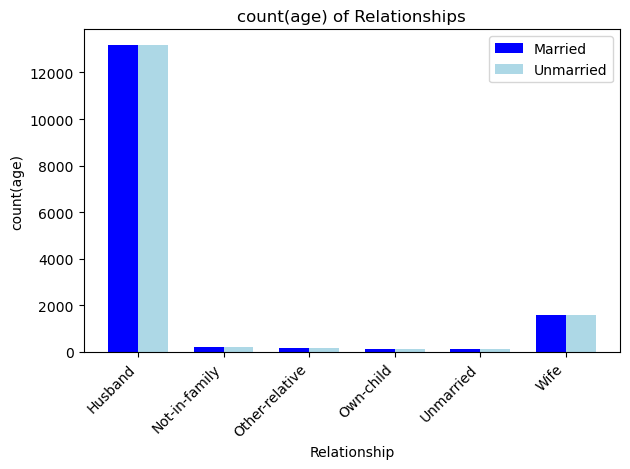

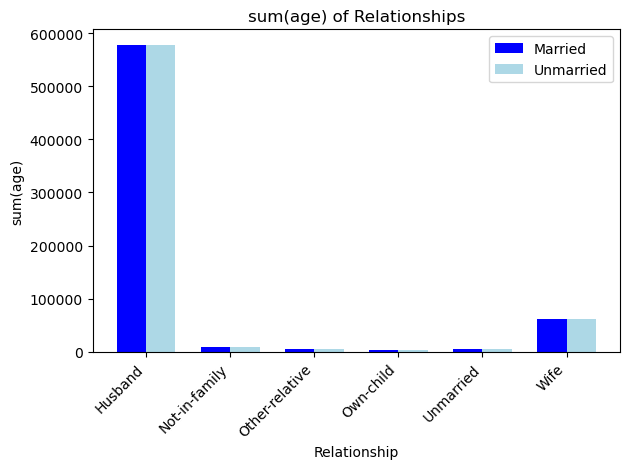

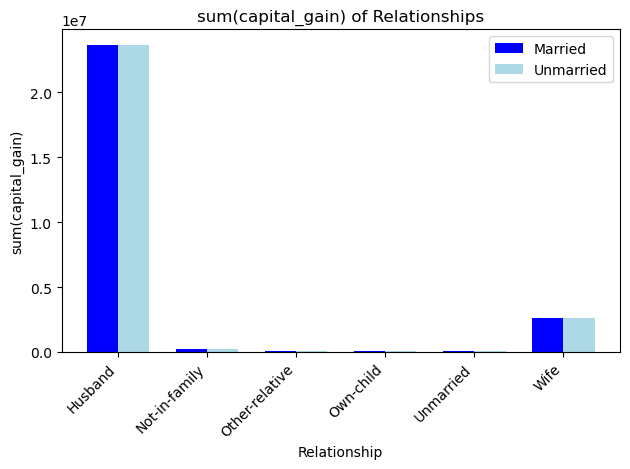

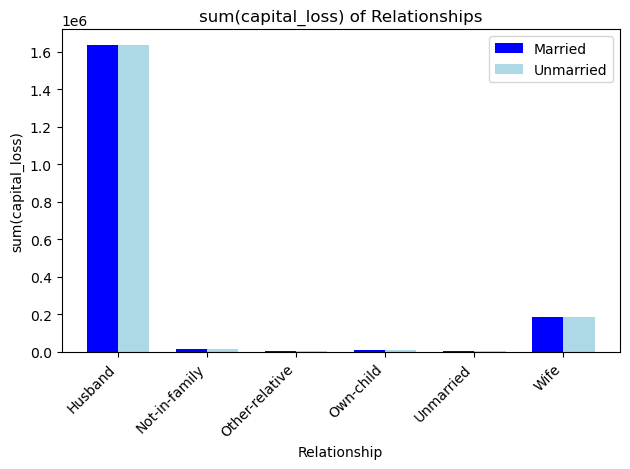

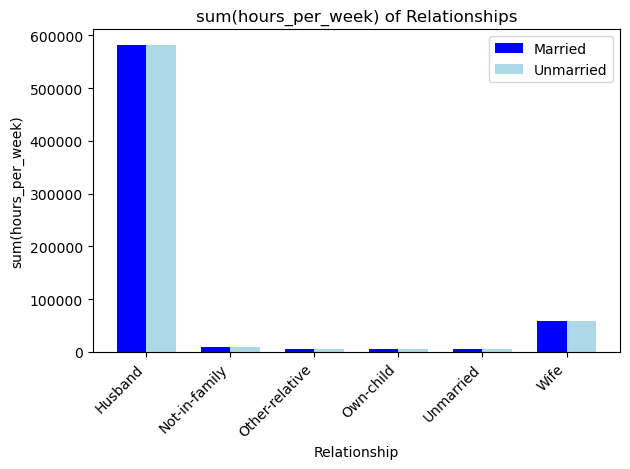

In [37]:
import os
import matplotlib.pyplot as plt
# final_reccos = [('relationship', 'age', 'sum'), ('relationship', 'capital_gain', 'sum'), ('relationship', 'capital_loss', 'sum'), ('relationship', 'hours_per_week', 'sum'), ('relationship', 'hours_per_week', 'count')]
labels = ['Married', 'Un-married']

folder_path = '../plots/'
os.makedirs(folder_path, exist_ok=True)

for vis in final_reccos:
    # print(vis)
    attribute, measure, function = view
    selections = ''
    selections = f'{vis[0]}, {vis[2]}({vis[1]})'        
    # print(selections)
    query_dataset_query = f"""
    SELECT {selections}
    FROM census
    WHERE {query_ds_cond}
    GROUP BY {vis[0]}
    ORDER BY {vis[0]}
"""
    # print(query_dataset_query)

    reference_dataset_query = f"""
    SELECT {selections}
    FROM census
    WHERE {ref_ds_cond}
    GROUP BY {vis[0]}
    ORDER BY {vis[0]}
"""
    # print(reference_dataset_query)
    cur.execute(query_dataset_query)
    table_query = np.array(cur.fetchall())
    # print(table_query)
    val_query = table_query[:,1].astype(float)
    # print(val_query)
    
    cur.execute(reference_dataset_query)
    table_reference = np.array(cur.fetchall())
    # print(table_reference)
    val_reference = table_reference[:,1].astype(float)
    # print(val_reference)
    
    label_query = table_query[:,0]
    a = val_query
    b = val_reference

    # Extracting labels and values_query dynamically from table_query
    labels_query = [row[0].strip() for row in table_query]
    values_query = [int(row[1]) for row in table_query]
    
    # Extracting values_reference dynamically from table_reference
    labels_reference = [row[0].strip() for row in table_reference]
    values_reference = [int(row[1]) if row[0].strip() in labels_query else 0 for row in table_query]
    
    # Combine labels from both datasets
    labels = list(set(labels_query) | set(labels_reference))
    labels.sort()
    
    # Ensure values_query and values_reference have the same length
    values_query_updated = [0] * len(labels)
    values_reference_updated = [0] * len(labels)   
    for i, label in enumerate(labels):
        if label in labels_query:
            index_query = labels_query.index(label)
            values_query_updated[i] = values_query[index_query]
        if label in labels_reference:
            index_reference = labels_reference.index(label)
            values_reference_updated[i] = values_reference[index_reference]

    x = np.arange(len(labels))

    width = 0.35
    fig, ax = plt.subplots()
    
    # Plot the bars for table_query
    rects1 = ax.bar(x - width/2, values_query, width, label='Married', color='blue')    
    # Plot the bars for table_reference
    rects2 = ax.bar(x + width/2, values_reference, width, label='Unmarried', color='lightblue')
    
    # Add labels, title, and legend
    ax.set_xlabel('Relationship')
    ax.set_ylabel(f'{vis[2]}({vis[1]})')
    ax.set_title(f'{vis[2]}({vis[1]})' + ' of Relationships')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Save the plot in the folder path
    plt.savefig(folder_path + measure + '(' + function + ')' + '_' + attribute +'.png', dpi=300)

    plt.close()
